
Testing mean aggregation...

Best ARIMA parameters for mean: (2, 1, 3)

Metrics:
RMSE: 21.4157
MAE: 7.1554
R2: -0.0146
MAPE: 2.5303


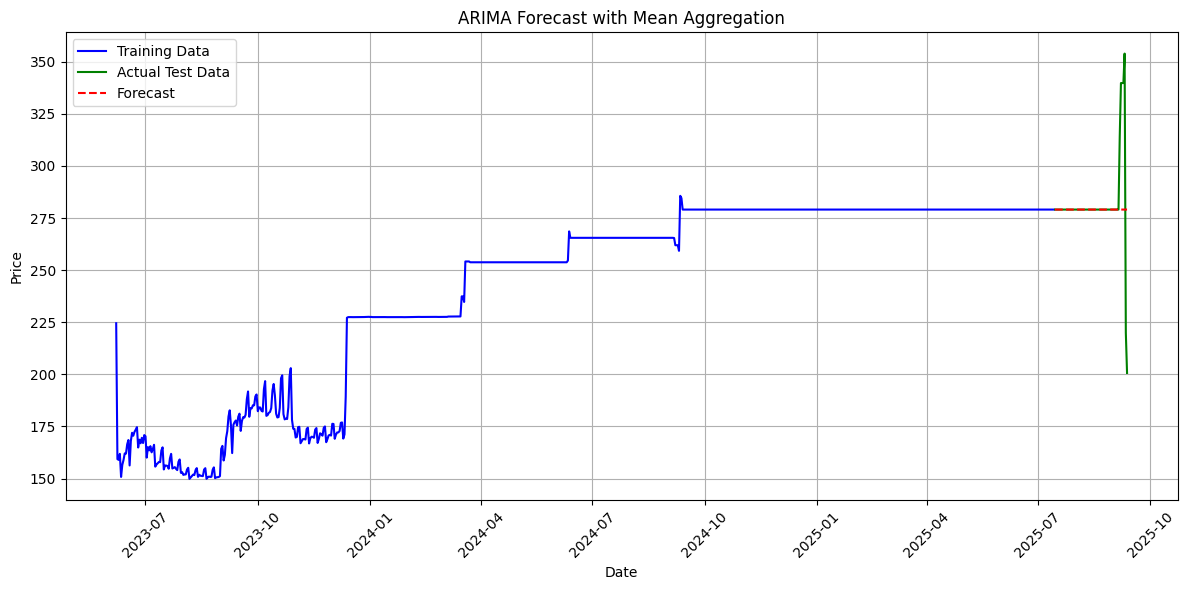


Testing median aggregation...

Best ARIMA parameters for median: (0, 1, 3)

Metrics:
RMSE: 8.4163
MAE: 2.6667
R2: -0.1116
MAPE: 1.7064


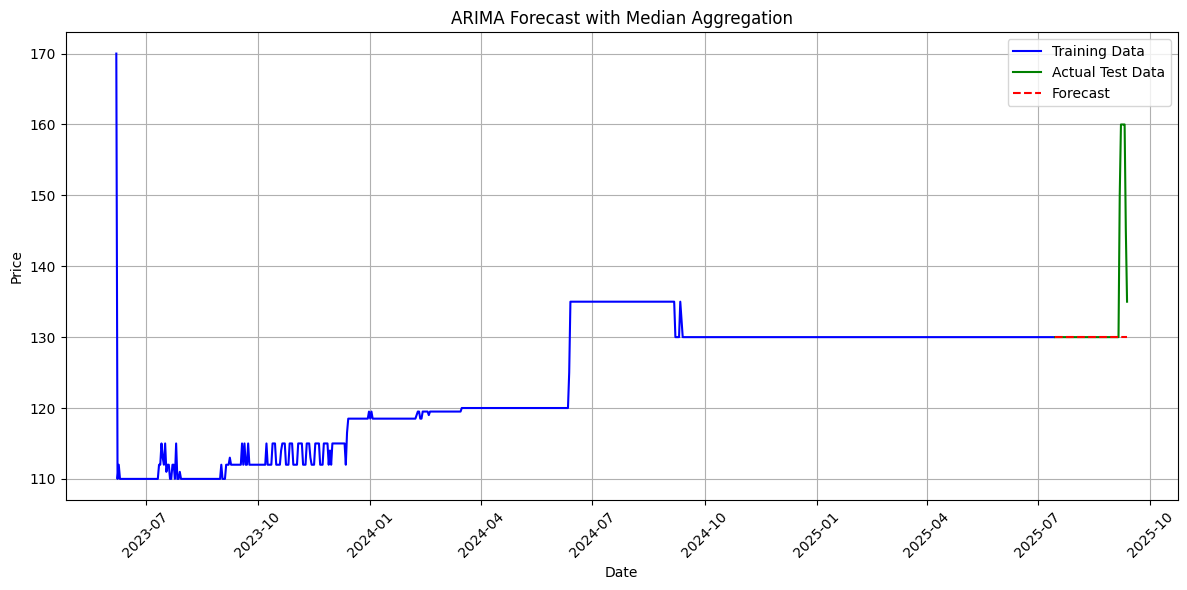


Testing percentile_75 aggregation...

Best ARIMA parameters for percentile_75: (3, 1, 3)

Metrics:
RMSE: 5.1191
MAE: 1.1875
R2: -0.0074
MAPE: 0.5142


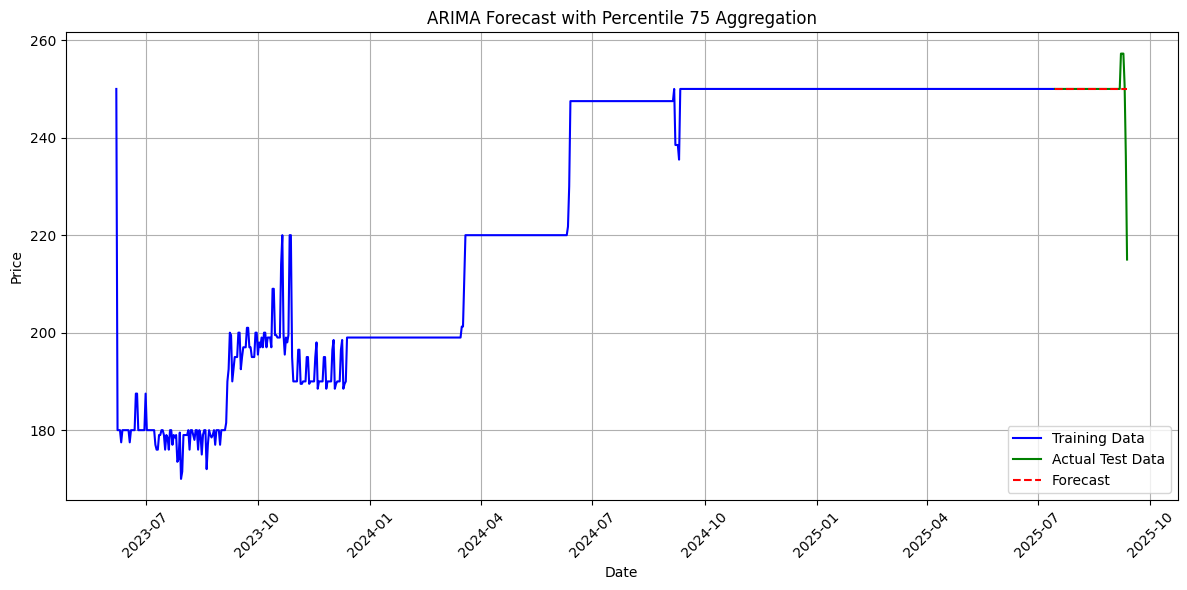


Testing percentile_25 aggregation...

Best ARIMA parameters for percentile_25: (3, 1, 3)

Metrics:
RMSE: 3.4157
MAE: 1.1667
R2: -0.1321
MAPE: 1.1667


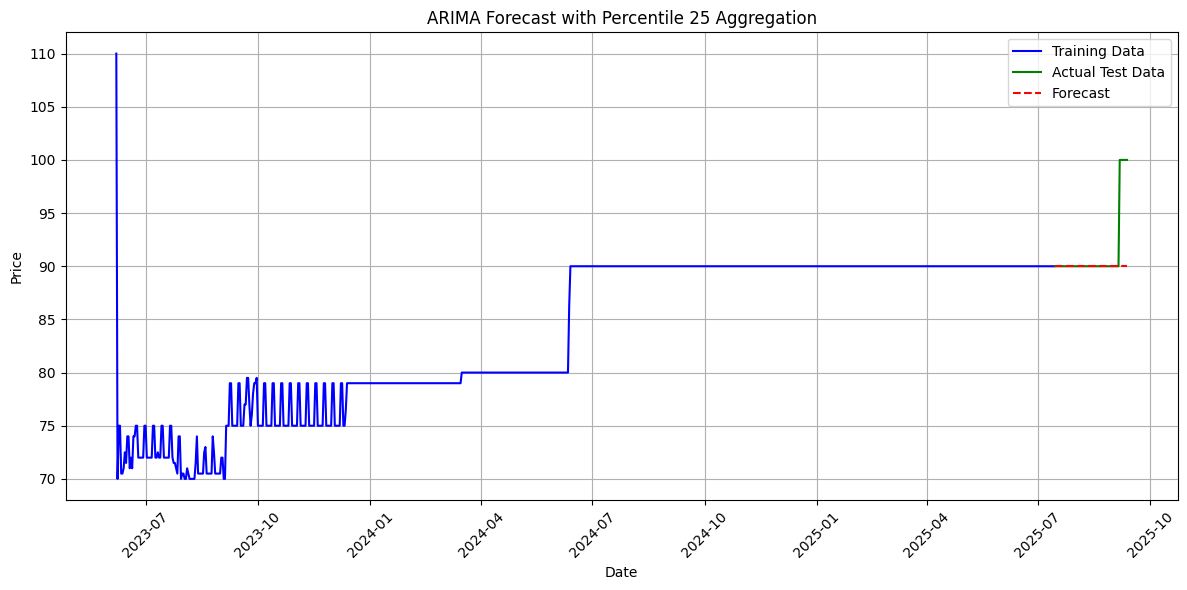


Analyzing neighborhood: Batignolles-Monceau
Best ARIMA parameters: (2, 1, 3)

Metrics:
RMSE: 100.2840
MAE: 33.9323
R2: -0.0221
MAPE: 6.3597

Analyzing neighborhood: Bourse
Best ARIMA parameters: (0, 1, 0)

Metrics:
RMSE: 9.7024
MAE: 2.6142
R2: -0.0492
MAPE: 1.1882

Analyzing neighborhood: Buttes-Chaumont
Best ARIMA parameters: (0, 1, 0)

Metrics:
RMSE: 22.4453
MAE: 6.8868
R2: -0.0492
MAPE: 2.4120

Analyzing neighborhood: Buttes-Montmartre
Best ARIMA parameters: (3, 1, 3)

Metrics:
RMSE: 3.7693
MAE: 1.2697
R2: -0.1280
MAPE: 0.8807

Analyzing neighborhood: Entrepôt
Best ARIMA parameters: (3, 1, 2)

Metrics:
RMSE: 5.3468
MAE: 1.6935
R2: -0.1110
MAPE: 0.9469

Analyzing neighborhood: Gobelins
Best ARIMA parameters: (3, 1, 2)

Metrics:
RMSE: 2.8821
MAE: 0.7401
R2: -0.0706
MAPE: 0.4256

Analyzing neighborhood: Hôtel-de-Ville
Best ARIMA parameters: (0, 1, 0)

Metrics:
RMSE: 188.6765
MAE: 62.8509
R2: -0.0092
MAPE: 10.8846

Analyzing neighborhood: Louvre
Best ARIMA parameters: (3, 1, 3)

Metric

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

def prepare_aggregated_data(calendar_path, listings_path, n_listings=500, aggregation_method='mean'):
    # Load listings first to get the sample and neighborhood info
    listings_df = pd.read_csv(listings_path)
    sampled_listings = listings_df['id'].sample(n=n_listings, random_state=42)
    
    # Create mapping of listing_id to neighborhood
    neighborhood_map = listings_df[['id', 'neighbourhood_cleansed']].set_index('id')
    
    # Load and filter calendar data
    calendar_df = pd.read_csv(calendar_path)
    calendar_df = calendar_df[calendar_df['listing_id'].isin(sampled_listings)]
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    
    # Convert price to numeric
    calendar_df['price'] = pd.to_numeric(calendar_df['price'], errors='coerce')
    
    # Add neighborhood information
    calendar_df['neighbourhood'] = calendar_df['listing_id'].map(neighborhood_map['neighbourhood_cleansed'])
    
    # Perform aggregation based on method
    if aggregation_method == 'mean':
        aggregated_data = calendar_df.groupby('date')['price'].mean()
    elif aggregation_method == 'median':
        aggregated_data = calendar_df.groupby('date')['price'].median()
    elif aggregation_method == 'percentile_75':
        aggregated_data = calendar_df.groupby('date')['price'].quantile(0.75)
    elif aggregation_method == 'percentile_25':
        aggregated_data = calendar_df.groupby('date')['price'].quantile(0.25)
    elif aggregation_method == 'by_neighborhood':
        aggregated_data = calendar_df.groupby(['date', 'neighbourhood'])['price'].mean().unstack()
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")
    
    # Sort by date
    aggregated_data = aggregated_data.sort_index()
    
    return aggregated_data

def grid_search_arima(data, p_range, d_range, q_range):
    """Perform grid search to find optimal ARIMA parameters."""
    best_aic = float('inf')
    best_params = None
    
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(data, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (p, d, q)
        except:
            continue
    
    return best_params

def train_and_evaluate_arima(data, forecast_horizon=60):
    """Train ARIMA model and evaluate performance."""
    # Calculate cutoff dates
    validation_start = data.index[-forecast_horizon]
    
    # Split into train and test
    train_data = data[data.index < validation_start]
    test_data = data[data.index >= validation_start]
    
    # Find best parameters
    best_params = grid_search_arima(
        train_data,
        p_range=range(0, 4),
        d_range=range(0, 2),
        q_range=range(0, 4)
    )
    
    if best_params is None:
        raise ValueError("Could not find suitable ARIMA parameters")
    
    # Train model
    model = ARIMA(train_data, order=best_params)
    results = model.fit()
    
    # Generate forecasts
    forecast = results.forecast(steps=forecast_horizon)
    
    # Calculate metrics
    metrics = {
        'rmse': np.sqrt(mean_squared_error(test_data, forecast)),
        'mae': mean_absolute_error(test_data, forecast),
        'r2': r2_score(test_data, forecast),
        'mape': np.mean(np.abs((test_data - forecast) / test_data)) * 100
    }
    
    return results, forecast, test_data, metrics, best_params

def plot_forecasts(train_data, test_data, forecast, title):
    """Plot the training data, test data, and forecasts."""
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(train_data.index, train_data.values, label='Training Data', color='blue')
    
    # Plot test data
    plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='green')
    
    # Plot forecast
    plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def compare_aggregation_methods(calendar_path, listings_path, n_listings=500):
    """Compare different aggregation methods for ARIMA modeling."""
    aggregation_methods = ['mean', 'median', 'percentile_75', 'percentile_25']
    results = {}
    
    for method in aggregation_methods:
        print(f"\nTesting {method} aggregation...")
        
        # Prepare data
        data = prepare_aggregated_data(calendar_path, listings_path, n_listings, method)
        
        try:
            # Train and evaluate model
            model_results, forecast, test_data, metrics, best_params = train_and_evaluate_arima(data)
            
            results[method] = {
                'metrics': metrics,
                'best_params': best_params,
                'forecast': forecast,
                'test_data': test_data,
                'train_data': data[data.index < test_data.index[0]]
            }
            
            # Print results
            print(f"\nBest ARIMA parameters for {method}: {best_params}")
            print("\nMetrics:")
            for metric, value in metrics.items():
                print(f"{metric.upper()}: {value:.4f}")
            
            # Plot results
            plot_forecasts(
                results[method]['train_data'],
                test_data,
                forecast,
                f'ARIMA Forecast with {method.replace("_", " ").title()} Aggregation'
            )
            
        except Exception as e:
            print(f"Error processing {method} aggregation: {str(e)}")
            continue
    
    return results

def analyze_neighborhood_patterns(calendar_path, listings_path, n_listings=500):
    """Analyze price patterns by neighborhood."""
    # Get neighborhood data
    data = prepare_aggregated_data(calendar_path, listings_path, n_listings, 'by_neighborhood')
    
    neighborhood_results = {}
    
    for neighborhood in data.columns:
        print(f"\nAnalyzing neighborhood: {neighborhood}")
        
        neighborhood_data = data[neighborhood].dropna()
        
        try:
            # Train and evaluate model
            model_results, forecast, test_data, metrics, best_params = train_and_evaluate_arima(neighborhood_data)
            
            neighborhood_results[neighborhood] = {
                'metrics': metrics,
                'best_params': best_params,
                'forecast': forecast,
                'test_data': test_data
            }
            
            # Print results
            print(f"Best ARIMA parameters: {best_params}")
            print("\nMetrics:")
            for metric, value in metrics.items():
                print(f"{metric.upper()}: {value:.4f}")
            
        except Exception as e:
            print(f"Error processing neighborhood {neighborhood}: {str(e)}")
            continue
    
    return neighborhood_results

# Main execution
if __name__ == "__main__":
    calendar_path = r'C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\paris_merged_calendar.csv'
    listings_path = r'C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\listings.csv'
    
    # Compare different aggregation methods
    aggregation_results = compare_aggregation_methods(calendar_path, listings_path)
    
    # Analyze neighborhood patterns
    neighborhood_results = analyze_neighborhood_patterns(calendar_path, listings_path)